In [64]:
import faiss
import os
import numpy as np
from IPython.display import display, Image
from PIL import Image as PILImage
import lmdb
import torch 
import io
from misc.model import joint_embedding
from torchvision import transforms
from misc.utils import save_obj, collate_fn_cap_padded, encode_sentence
import h5py

In [74]:
device = torch.device("cuda")
index_path = "flickr30k_flat_full.index"
h5_path = "embeddings_sentences_full.h5"
model_path = "weights/best_correct_full_cs.pth.tar"
dict_path = "/data/m.portaz/wiki.multi.en.vec"

index = faiss.read_index(str(index_path))
index_search = index.search

In [75]:
checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)

join_emb = joint_embedding(checkpoint['args_dict'])
join_emb.load_state_dict(checkpoint["state_dict"])

for param in join_emb.parameters():
    param.requires_grad = False

join_emb.to(device)
join_emb.eval()

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

prepro_val = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
    normalize,
])


tf_img = prepro_val

def load_vec(emb_path):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id
embeddings, id2word, word2id = load_vec(dict_path)

def get_features_sentence(sentence):
    input_sentence = encode_sentence(sentence, embeddings, word2id)
    input_caps = input_sentence.unsqueeze(0).to(device)

    with torch.no_grad():
        _, output_emb = join_emb(None, input_caps, [len(sentence.split(' '))])
    return output_emb.detach().cpu().numpy()

In [76]:
def getSentences(uuids):
    with h5py.File(h5_path, 'r') as f:
        sentences = f['sentence']
        for caption_id in uuids[0]:
            print(sentences[int(caption_id)])

In [77]:
def printNeighboursSentence(sentence,  nb_neigbours):
    embedding_words = get_features_sentence(sentence)
    dists, uuids = index_search(embedding_words, nb_neigbours)
    getSentences(uuids)

In [78]:
printNeighboursSentence('a man walks on a beach', 10)

ein lächelnder junger mann geht in der nähe des strandes vorbei und trägt dabei eine baseballkappe , ein blaues t-shirt und jeans .

a barefoot boy with a blue and white striped towel is standing on the beach .

a man on a beach building a sand castle .

a smiling young man walking on next to the beach wearing a baseball cap , blue t-shirt and jeans .

ein mann an einem strand baut eine sandburg .

un jeune homme souriant , marchant au bord de la plage avec une casquette , un t-shirt bleu et un jean .

ein barfüßiger junge mit einem blau-weiß gestreiften handtuch steht am strand .

ein mann rasiert sich , während er am strand vor dem meer sitzt .

eine person mit neonpinkfarbenem haar und gelbem t-shirt blickt über einen strand .

un homme se rase , assis sur la plage devant l&apos; océan .



In [55]:
def get_features_image(image_path):
    img = PILImage.open(image_path, mode="r")

    if img.mode is 'L':
        rgbimg = Image.new("RGB", img.size)
        rgbimg.paste(img)
        img = rgbimg
    if img.mode is not 'RGB':
        img = img.convert('RGB')

    img = tf_img(img)

    input_img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        output, _ = join_emb(input_img, None, None)
    return output.detach().cpu().numpy()

In [62]:
def printNeighboursImages(image_path, nb_neigbours):
    embedding_image = get_features_image(image_path)
    edists, uuids = index_search(embedding_image, nb_neigbours)
    getSentences(uuids)

In [82]:
printNeighboursImages('/data/a.nivaggioli/features/manWalkingOnBeach.png', 10)

a man on a beach building a sand castle .

eine person mit neonpinkfarbenem haar und gelbem t-shirt blickt über einen strand .

ein barfüßiger junge mit einem blau-weiß gestreiften handtuch steht am strand .

ein mann an einem strand baut eine sandburg .

un homme sur une plage construisant un château de sable .

un jeune homme souriant , marchant au bord de la plage avec une casquette , un t-shirt bleu et un jean .

un homme debout sur une jetée à côté d&apos; un bateau sur un lac paisible .

a smiling young man walking on next to the beach wearing a baseball cap , blue t-shirt and jeans .

un homme se rase , assis sur la plage devant l&apos; océan .

ein mann rasiert sich , während er am strand vor dem meer sitzt .



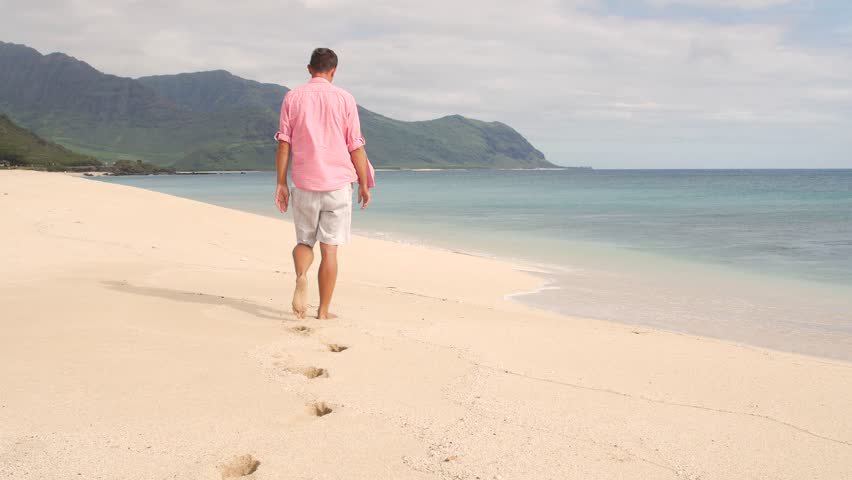

In [80]:
PILImage.open('/data/a.nivaggioli/features/manWalkingOnBeach.png')